Preperation
We first start with imports,

In [1]:
import torch
from odak.learn.wave import calculate_phase, calculate_amplitude, wavenumber, propagate_beam, produce_phase_only_slm_pattern, set_amplitude, generate_complex_field, linear_grating
from odak.learn.tools import zero_pad, crop_center, save_image,load_image
from odak import np
from tqdm import tqdm

Let's define our wavelength for our light source and calculate wavenumber.

In [2]:
wavelength = 515e-9
k = wavenumber(wavelength)

Pixel pitch and resolution of the phase-only hologram or a phase-only spatial light modulator that we are simulating:

In [3]:
dx = 0.000008
resolution = [1080,1920]

Define the deired distance that the optical reconsturction will form away from the optimized phase pattern.

In [4]:
distance = 0.15

We need to set a target image that we want to reconstruct in a holographic display. Either we can load a sample image here or create a white square on a black background like in this example.

In [5]:
square_size = 100
target = torch.zeros(resolution[0],resolution[1])
target[round((resolution[0]-square_size)/2):round((resolution[0]+square_size)/2),round((resolution[1]-square_size)/2):round((resolution[1]+square_size)/2)] = 1.

Lets visualize the target image to see what we have compiled so far:

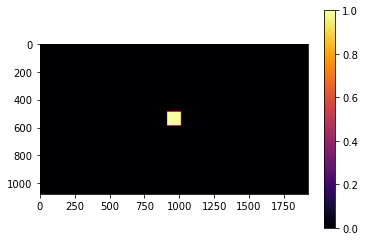

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(target, cmap=cm.inferno)
plt.colorbar()
plt.show()

In order simulate the travelling light we need to represent the light propagation in free space. There are different possibilities but In this example we will use transfer function Fresnel approach. 

In [7]:
propagation_type = 'TR Fresnel'

We nee to define our SLM's modulation and dynamic range. Depending on your SLM's calibration and dynamic range things may vary.

In [8]:
slm_range = 2*np.pi
dynamic_range = 255

We need number of iterarions.

In [9]:
iteration_number = 100
t = tqdm(range(iteration_number), leave=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Lets initiliaze our complex field at the hologram plane.

In [10]:
phase = torch.rand(resolution[0], resolution[1])
amplitude = torch.ones_like(target)
hologram = generate_complex_field(amplitude,phase)

## Gradient Descent Algorithm
  

Let's first make sure to set our loss function (L2) and a hyperparameter that helps with the convergence.

In [11]:
loss_function = torch.nn.MSELoss(reduction='none')
alpha = 0.1

We will proceed with implementing our gradient descent based phase-only hologram optimization.
The key idea is to backpropagate the loss generated from each iteration to hologram and subtracting it from the hologram in a weighted fashion.
Note that at the end, the hologram's phase is the only effected quantity from these updates.

In [12]:
for i in t:
    hologram_padded = zero_pad(hologram)
    recon_field = propagate_beam(hologram_padded, k, distance, dx, wavelength, propagation_type)
    recon_field_cropped = crop_center(recon_field)
    recon_intensity = calculate_amplitude(recon_field_cropped)**2
    loss = loss_function(recon_intensity, target)
    loss_field = generate_complex_field(loss, calculate_phase(recon_field_cropped))
    loss_field_padded = zero_pad(loss_field)
    loss_propagated_padded = propagate_beam(loss_field_padded, k, -distance, dx, wavelength, propagation_type)
    loss_propagated = crop_center(loss_propagated_padded)
    hologram_updated = hologram - alpha * loss_propagated
    hologram_phase = calculate_phase(hologram_updated)
    hologram = generate_complex_field(amplitude, hologram_phase)
    t.set_description('Loss:{:.4f}'.format(torch.mean(loss)))

/home/kaan/.local/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Now we have the optimized complex field for the hologram plane. In order to visulize the simulated result at the reconstruction plane we need to propagate the complex field to the reconstruction plane.  

In [13]:
hologram_padded = zero_pad(hologram)
reconstruction = propagate_beam(hologram_padded, k, distance, dx, wavelength, propagation_type)
reconstruction = crop_center(reconstruction)

Now we have simulated reconstruction available to us, lets save it as a image.

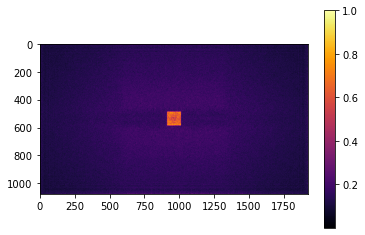

In [14]:
reconstruction_amp = calculate_amplitude(reconstruction)
reconstruction_intensity = (reconstruction_amp / reconstruction_amp.max())**2
save_image('reconstructed_image.png',reconstruction_intensity,cmin=0.,cmax=1.)

plt.imshow(reconstruction_intensity, cmap=cm.inferno)
plt.colorbar()
plt.show()

Now we can save our phase-only hologram.

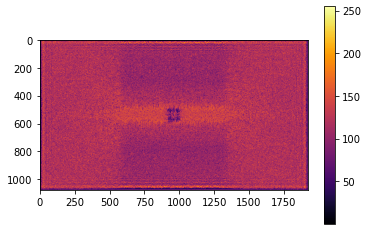

In [15]:
phase_hologram = calculate_phase(hologram)
phase_only_hologram = (phase_hologram % slm_range) / slm_range * dynamic_range
save_image('phase_only_hologram.png', phase_only_hologram)

plt.imshow(phase_only_hologram, cmap=cm.inferno)
plt.colorbar()
plt.show()

In some cases, you may want to add a grating term to your hologram as you will display it on a spatial light modulator. There are various reasons for that, but the most obvious is getting rid of zeroth-order reflections that are not modulated by your hologram. 

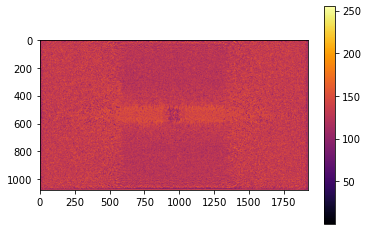

In [16]:
grating = linear_grating(resolution[0],resolution[1],axis='y').to(phase_hologram.device)
phase_only_hologram_w_grating = phase_hologram + calculate_phase(grating)
phase_only_hologram_w_grating = (phase_only_hologram_w_grating % slm_range) / slm_range * dynamic_range
save_image('phase_only_hologram_w_grating.png', phase_only_hologram_w_grating)

plt.imshow(phase_only_hologram_w_grating, cmap=cm.inferno)
plt.colorbar()
plt.show()